In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


buildingblock1_smiles- 첫 번째 빌딩 블록의 구조(SMILES)  
buildingblock2_smiles- 두 번째 빌딩 블록의 구조(SMILES)  
buildingblock3_smiles- 세 번째 빌딩 블록의 구조(SMILES)  
molecule_smiles- 완전히 조립된 분자의 구조(SMILES). 여기에는 세 가지 빌딩 블록과 트리아진 코어가 포함됩니다.   
우리는 DNA 링커의 대체물로 a를 사용합니다.
protein_name- 단백질 표적 이름

*binds- 대상 열입니다. 분자가 단백질에 결합하는지 여부에 대한 이진 클래스 라벨입니다. 테스트 세트에는 사용할 수 없습니다.*

# 0. SETTING

In [ ]:
dataPath= '/content/drive/MyDrive/belka/'

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pyarrow.parquet as pq

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 40.5 MB/s eta 0:00:00


# 0. DATA Loading

In [ ]:
train_set = pl.read_parquet(dataPath + 'train.parquet',n_rows = 100000)
test_set = pl.read_parquet(dataPath + 'test.parquet')

In [ ]:
train_set['protein_name'].unique()

protein_name
str
"""sEH"""
"""BRD4"""
"""HSA"""


In [ ]:
train_set['binds'].value_counts()

binds,count
i64,u32
1,235
0,99765


# 1. EDA

바인드 하는 chemicals의 특징이 구조랑 연관있는지

In [ ]:
import polars as pl

# Parquet 파일을 LazyFrame으로 스캔
lazy_train_set = pl.scan_parquet(dataPath + 'train.parquet')

# bind가 1인 데이터 필터링
bind_1_train_set = lazy_train_set.filter(pl.col('binds') == 1).collect()

# 결과 확인 (원하는 경우)
print(bind_1_train_set)


shape: (1_589_906, 7)
┌───────────┬───────────────┬───────────────┬───────────────┬───────────────┬──────────────┬───────┐
│ id        ┆ buildingblock ┆ buildingblock ┆ buildingblock ┆ molecule_smil ┆ protein_name ┆ binds │
│ ---       ┆ 1_smiles      ┆ 2_smiles      ┆ 3_smiles      ┆ es            ┆ ---          ┆ ---   │
│ i64       ┆ ---           ┆ ---           ┆ ---           ┆ ---           ┆ str          ┆ i64   │
│           ┆ str           ┆ str           ┆ str           ┆ str           ┆              ┆       │
╞═══════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪══════════════╪═══════╡
│ 466       ┆ C#CC[C@@H](CC ┆ C#CCOc1ccc(CN ┆ Cc1cc2cc(CN)c ┆ C#CCOc1ccc(CN ┆ HSA          ┆ 1     │
│           ┆ (=O)O)NC(=O)O ┆ )cc1.Cl       ┆ cc2[nH]1      ┆ c2nc(NCc3ccc4 ┆              ┆       │
│           ┆ CC1c2c…       ┆               ┆               ┆ [nH]c(…       ┆              ┆       │
│ 467       ┆ C#CC[C@@H](CC ┆ C#CCOc1ccc(CN ┆ Cc1cc2cc(CN)c ┆ C#CCOc1

In [ ]:
bind_1_train_set['protein_name'].value_counts()

protein_name,count
str,u32
"""BRD4""",456964
"""sEH""",724532
"""HSA""",408410


In [ ]:
# 단백질 리스트
proteins = ['HSA', 'BRD4', 'sEH']

# 각 단백질에 대해 데이터셋을 10000개씩 나누기
sampled_datasets = []
for protein in proteins:
    protein_dataset = bind_1_train_set.filter(pl.col('protein_name') == protein)
    sampled_dataset = protein_dataset.sample(n=10000, with_replacement=False)
    sampled_datasets.append(sampled_dataset)

# 모든 단백질 데이터셋을 하나로 합치기
combined_dataset = pl.concat(sampled_datasets)

# 'protein_name' 열 제거
final_dataset = combined_dataset.drop('protein_name')

# 결과 확인
print(final_dataset)


shape: (30_000, 6)
┌───────────┬───────────────────┬───────────────────┬───────────────────┬──────────────────┬───────┐
│ id        ┆ buildingblock1_sm ┆ buildingblock2_sm ┆ buildingblock3_sm ┆ molecule_smiles  ┆ binds │
│ ---       ┆ iles              ┆ iles              ┆ iles              ┆ ---              ┆ ---   │
│ i64       ┆ ---               ┆ ---               ┆ ---               ┆ str              ┆ i64   │
│           ┆ str               ┆ str               ┆ str               ┆                  ┆       │
╞═══════════╪═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╪═══════╡
│ 7851118   ┆ C=CCC[C@@H](NC(=O ┆ COC[C@H](CN)OC    ┆ Cc1cc2cc(CN)ccc2[ ┆ C=CCC[C@@H](Nc1n ┆ 1     │
│           ┆ )OCC1c2ccccc2-c…  ┆                   ┆ nH]1              ┆ c(NCc2ccc3[nH]c( ┆       │
│           ┆                   ┆                   ┆                   ┆ …                ┆       │
│ 183991600 ┆ O=C(Nc1ccc(C(=O)O ┆ Nc1ccc2c(c1)CNCC2 ┆ Cl.Cl.Cn1ccnc1Cn1 

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

In [ ]:
# ECFP 생성 함수
def generate_ecfp(smiles, radius=2, n_bits=1024):
    """
    Generate ECFP (Extended Connectivity Fingerprint) for a given SMILES string.

    Parameters:
    smiles (str): The SMILES string of the molecule.
    radius (int): The radius parameter for ECFP. Default is 2.
    n_bits (int): The size of the fingerprint. Default is 1024.

    Returns:
    dict: A dictionary representing the ECFP bit vector with keys as X1, X2, ..., Xn.
    """
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")

    # Generate ECFP (Morgan Fingerprint)
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)

    # Convert the fingerprint to a dictionary with keys X1, X2, ..., Xn
    ecfp_dict = {f'X_{i+1}': int(bit) for i, bit in enumerate(ecfp.ToBitString())}

    return ecfp_dict

# 데이터프레임을 받아서 처리하는 함수
def process_dataframe(df):
    # 'smiles'로 끝나는 모든 열 이름 찾기
    smiles_columns = [col for col in df.columns if col.endswith('smiles')]

    # 각 'smiles' 열에 대해 ECFP 생성 및 데이터프레임에 추가
    for smiles_col in smiles_columns:
        ecfp_data = []
        for smiles in tqdm(df[smiles_col], desc=f"Generating ECFP for {smiles_col}"):
            ecfp_data.append(generate_ecfp(smiles))

        # ECFP 데이터를 데이터프레임으로 변환하고 열 이름 변경
        ecfp_df = pl.DataFrame(ecfp_data)
        ecfp_df.columns = [f'{smiles_col}_{col}' for col in ecfp_df.columns]

        # 원래 데이터프레임에 ECFP 데이터 추가
        df = df.hstack(ecfp_df)

        # 'smiles' 열 제거 (선택 사항)
        df = df.drop(smiles_col)

    return df

In [ ]:
# 데이터프레임 처리
processed_df = process_dataframe(final_dataset)

# 결과 확인
print(processed_df)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATION WARNING: please use MorganGenerator
[00:21:05] DEPRECATI

shape: (30_000, 4_098)
┌───────────┬───────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ id        ┆ binds ┆ buildingbl ┆ buildingbl ┆ … ┆ molecule_s ┆ molecule_ ┆ molecule_ ┆ molecule_ │
│ ---       ┆ ---   ┆ ock1_smile ┆ ock1_smile ┆   ┆ miles_X_10 ┆ smiles_X_ ┆ smiles_X_ ┆ smiles_X_ │
│ i64       ┆ i64   ┆ s_X_1      ┆ s_X_2      ┆   ┆ 21         ┆ 1022      ┆ 1023      ┆ 1024      │
│           ┆       ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│           ┆       ┆ i64        ┆ i64        ┆   ┆ i64        ┆ i64       ┆ i64       ┆ i64       │
╞═══════════╪═══════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 7851118   ┆ 1     ┆ 0          ┆ 1          ┆ … ┆ 0          ┆ 0         ┆ 1         ┆ 1         │
│ 183991600 ┆ 1     ┆ 0          ┆ 0          ┆ … ┆ 0          ┆ 0         ┆ 0         ┆ 0         │
│ 153031120 ┆ 1     ┆ 0          ┆ 0          ┆ … ┆ 0          ┆ 0  

In [ ]:
processed_df_pandas = processed_df.to_pandas()

In [ ]:
from sklearn.cluster import KMeans
# 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(processed_df_pandas)

# 결과 데이터프레임에 클러스터 열 추가
processed_df_pandas['cluster'] = clusters

# 결과 출력
print(processed_df_pandas)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


              id  binds  buildingblock1_smiles_X_1  buildingblock1_smiles_X_2  \
0        7851118      1                          0                          1   
1      183991600      1                          0                          0   
2      153031120      1                          0                          0   
3       18165766      1                          0                          1   
4      102461869      1                          0                          1   
...          ...    ...                        ...                        ...   
29995  125090699      1                          0                          1   
29996  125326136      1                          0                          1   
29997  125701886      1                          0                          1   
29998   83735852      1                          0                          0   
29999   82318166      1                          0                          0   

       buildingblock1_smile

In [ ]:
from sklearn.decomposition import PCA
# PCA를 사용하여 데이터 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_df_pandas.drop(columns=['cluster']))

# PCA 결과를 데이터프레임에 추가
processed_df_pandas['pca1'] = pca_result[:, 0]
processed_df_pandas['pca2'] = pca_result[:, 1]



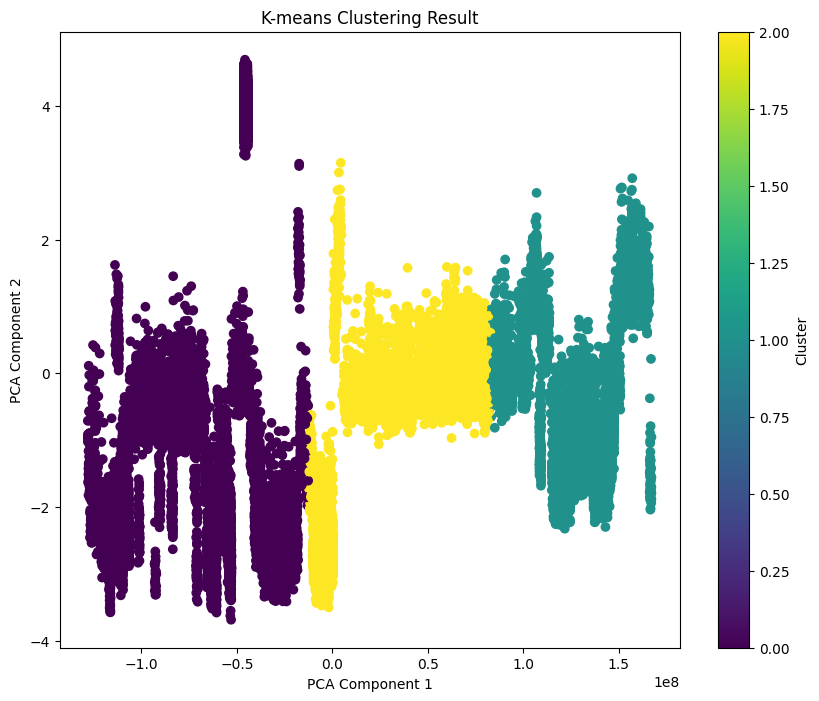

In [ ]:
import matplotlib.pyplot as plt
# 클러스터링 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(processed_df_pandas['pca1'], processed_df_pandas['pca2'], c=processed_df_pandas['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering Result')
plt.colorbar(label='Cluster')
plt.show()

--> 잘 나뉨 ECFP로 ㄱㄱ

# 2. Preprocessing

In [ ]:
# EDA 했으면 모든 변수 삭제
%reset -f

# 추가로 gc (garbage collector)를 이용해 메모리 해제
import gc
gc.collect()


0

데이터 로딩 다시하고 오기

## dataset 나누기

In [ ]:
# HSA
import polars as pl
import os

# Parquet 파일을 LazyFrame으로 스캔
data_path = '/content/drive/MyDrive/belka/'  # 데이터 파일의 실제 경로로 바꾸세요
output_path = '/content/drive/MyDrive/belka/'  # CSV 파일을 저장할 경로로 바꾸세요
os.makedirs(output_path, exist_ok=True)

lazy_train_set = pl.scan_parquet(data_path + 'train.parquet')

# 단백질이 HSA인 데이터 필터링
hsa_data = lazy_train_set.filter(pl.col('protein_name') == 'HSA')

# 데이터셋 크기와 분할 크기 설정
chunk_size = 100000

# 전체 데이터 수 계산
total_size = hsa_data.select(pl.count()).collect().item()
print(total_size)
# 데이터셋 분할 및 저장
for i in range(0, total_size, chunk_size):
    chunk = hsa_data.slice(i, chunk_size).collect(streaming=True)  # Streaming collection to manage memory usage

    file_name = f'hsa_dataset_chunk_{i // chunk_size + 1}.csv'
    chunk.write_csv(os.path.join(output_path, file_name))

    print(f'Chunk {i // chunk_size + 1} saved as {file_name}')

98415610
Chunk 1 saved as hsa_dataset_chunk_1.csv
Chunk 2 saved as hsa_dataset_chunk_2.csv
Chunk 3 saved as hsa_dataset_chunk_3.csv
Chunk 4 saved as hsa_dataset_chunk_4.csv
Chunk 5 saved as hsa_dataset_chunk_5.csv
Chunk 6 saved as hsa_dataset_chunk_6.csv
Chunk 7 saved as hsa_dataset_chunk_7.csv
Chunk 8 saved as hsa_dataset_chunk_8.csv
Chunk 9 saved as hsa_dataset_chunk_9.csv
Chunk 10 saved as hsa_dataset_chunk_10.csv
Chunk 11 saved as hsa_dataset_chunk_11.csv
Chunk 12 saved as hsa_dataset_chunk_12.csv
Chunk 13 saved as hsa_dataset_chunk_13.csv
Chunk 14 saved as hsa_dataset_chunk_14.csv
Chunk 15 saved as hsa_dataset_chunk_15.csv
Chunk 16 saved as hsa_dataset_chunk_16.csv
Chunk 17 saved as hsa_dataset_chunk_17.csv
Chunk 18 saved as hsa_dataset_chunk_18.csv
Chunk 19 saved as hsa_dataset_chunk_19.csv
Chunk 20 saved as hsa_dataset_chunk_20.csv
Chunk 21 saved as hsa_dataset_chunk_21.csv
Chunk 22 saved as hsa_dataset_chunk_22.csv
Chunk 23 saved as hsa_dataset_chunk_23.csv
Chunk 24 saved as hs

KeyboardInterrupt: 

In [ ]:
# BRD4
import polars as pl
import os

# Parquet 파일을 LazyFrame으로 스캔
data_path = '/content/drive/MyDrive/belka/'  # 데이터 파일의 실제 경로로 바꾸세요
output_path = '/content/drive/MyDrive/belka/'  # CSV 파일을 저장할 경로로 바꾸세요
os.makedirs(output_path, exist_ok=True)

lazy_train_set = pl.scan_parquet(data_path + 'train.parquet')
BRD4_data = lazy_train_set.filter(pl.col('protein_name') == 'BRD4')

# 데이터셋 크기와 분할 크기 설정
chunk_size = 100000

# 전체 데이터 수 계산
total_size = BRD4_data.select(pl.count()).collect().item()
print(total_size)
# 데이터셋 분할 및 저장
for i in range(0, total_size, chunk_size):
    chunk = BRD4_data.slice(i, chunk_size).collect(streaming=True)  # Streaming collection to manage memory usage

    file_name = f'BRD4_dataset_chunk_{i // chunk_size + 1}.csv'
    chunk.write_csv(os.path.join(output_path, file_name))

    print(f'Chunk {i // chunk_size + 1} saved as {file_name}')

98415610
Chunk 1 saved as BRD4_dataset_chunk_1.csv
Chunk 2 saved as BRD4_dataset_chunk_2.csv
Chunk 3 saved as BRD4_dataset_chunk_3.csv
Chunk 4 saved as BRD4_dataset_chunk_4.csv
Chunk 5 saved as BRD4_dataset_chunk_5.csv
Chunk 6 saved as BRD4_dataset_chunk_6.csv
Chunk 7 saved as BRD4_dataset_chunk_7.csv
Chunk 8 saved as BRD4_dataset_chunk_8.csv
Chunk 9 saved as BRD4_dataset_chunk_9.csv
Chunk 10 saved as BRD4_dataset_chunk_10.csv
Chunk 11 saved as BRD4_dataset_chunk_11.csv
Chunk 12 saved as BRD4_dataset_chunk_12.csv
Chunk 13 saved as BRD4_dataset_chunk_13.csv
Chunk 14 saved as BRD4_dataset_chunk_14.csv
Chunk 15 saved as BRD4_dataset_chunk_15.csv
Chunk 16 saved as BRD4_dataset_chunk_16.csv
Chunk 17 saved as BRD4_dataset_chunk_17.csv
Chunk 18 saved as BRD4_dataset_chunk_18.csv
Chunk 19 saved as BRD4_dataset_chunk_19.csv
Chunk 20 saved as BRD4_dataset_chunk_20.csv
Chunk 21 saved as BRD4_dataset_chunk_21.csv
Chunk 22 saved as BRD4_dataset_chunk_22.csv
Chunk 23 saved as BRD4_dataset_chunk_23.c

KeyboardInterrupt: 

In [ ]:
# sEH
import polars as pl
import os

# Parquet 파일을 LazyFrame으로 스캔
data_path = '/content/drive/MyDrive/belka/'  # 데이터 파일의 실제 경로로 바꾸세요
output_path = '/content/drive/MyDrive/belka/'  # CSV 파일을 저장할 경로로 바꾸세요
os.makedirs(output_path, exist_ok=True)

lazy_train_set = pl.scan_parquet(data_path + 'train.parquet')
sEH_data = lazy_train_set.filter(pl.col('protein_name') == 'sEH')

# 데이터셋 크기와 분할 크기 설정
chunk_size = 100000

# 전체 데이터 수 계산
total_size = sEH_data.select(pl.count()).collect().item()
print(total_size)
# 데이터셋 분할 및 저장
for i in range(0, total_size, chunk_size):
    chunk = sEH_data.slice(i, chunk_size).collect(streaming=True)  # Streaming collection to manage memory usage

    file_name = f'seH_dataset_chunk_{i // chunk_size + 1}.csv'
    chunk.write_csv(os.path.join(output_path, file_name))

    print(f'Chunk {i // chunk_size + 1} saved as {file_name}')

## Smiles

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from tqdm import tqdm

In [ ]:
def generate_ecfp(smiles, radius=2, n_bits=1024):
    """
    Generate ECFP (Extended Connectivity Fingerprint) for a given SMILES string.

    Parameters:
    smiles (str): The SMILES string of the molecule.
    radius (int): The radius parameter for ECFP. Default is 2.
    n_bits (int): The size of the fingerprint. Default is 1024.

    Returns:
    dict: A dictionary representing the ECFP bit vector with keys as X1, X2, ..., Xn.
    """
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")

    # Generate ECFP (Morgan Fingerprint)
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)

    # Convert the fingerprint to a dictionary with keys X1, X2, ..., Xn
    ecfp_dict = {f'X_{i+1}': int(bit) for i, bit in enumerate(ecfp.ToBitString())}

    return ecfp_dict

In [ ]:
def process_dataframe(df):
    """
    Process a DataFrame to generate ECFP for each SMILES column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing SMILES strings.

    Returns:
    pd.DataFrame: The DataFrame with ECFP data appended.
    """
    # 'smiles'로 끝나는 모든 열 이름 찾기
    smiles_columns = [col for col in df.columns if col.endswith('smiles')]

    # 각 'smiles' 열에 대해 ECFP 생성 및 데이터프레임에 추가
    for smiles_col in smiles_columns:
        ecfp_data = []
        for smiles in tqdm(df[smiles_col], desc=f"Generating ECFP for {smiles_col}"):
            ecfp_data.append(generate_ecfp(smiles))

        # ECFP 데이터를 데이터프레임으로 변환하고 열 이름 변경
        ecfp_df = pd.DataFrame(ecfp_data)
        ecfp_df.columns = [f'{smiles_col}_{col}' for col in ecfp_df.columns]

        # 원래 데이터프레임에 ECFP 데이터 추가
        df = pd.concat([df, ecfp_df], axis=1)

        # 'smiles' 열 제거 (선택 사항)
        df = df.drop(smiles_col, axis=1)

    return df

## Molecular Descriptor

In [ ]:
!pip install mordred
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176720 sha256=0f120ecd5d2e518f472bd9bafb8bd268c91c9dde2c90c569ad109bec260f124e
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cu

In [ ]:
import pandas as pd
from mordred import Calculator, descriptors
from rdkit import Chem
import os

def All_Mordred_descriptors(data, chunk_size=10000, output_file='descriptors.csv', progress_file='progress.txt'):
    calc = Calculator(descriptors, ignore_3D=False)
    total_chunks = (len(data) // chunk_size) + 1

    # 이전 진행 상황 확인
    if os.path.exists(progress_file):
        with open(progress_file, 'r') as f:
            last_processed_chunk = int(f.read().strip())
    else:
        last_processed_chunk = -1

    # CSV 파일이 이미 존재하는 경우 처리
    if os.path.exists(output_file):
        file_mode = 'a'  # append mode
        header = False
    else:
        file_mode = 'w'  # write mode
        header = True

    for i in range(last_processed_chunk + 1, total_chunks):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size
        chunk_data = data[start_idx:end_idx]
        mols = [Chem.MolFromSmiles(smi) for smi in chunk_data]
        df = calc.pandas(mols)

        # 데이터 타입 문제 해결
        for column in df.columns:
            if df[column].dtype == 'object':
                df[column] = df[column].astype(str)

        # 결과를 CSV 파일에 저장
        df.to_csv(output_file, mode=file_mode, header=header, index=False)

        # 이후의 청크들은 append 모드로 설정하고, 헤더를 추가하지 않음
        file_mode = 'a'
        header = False

        print(f"Chunk {i+1}/{total_chunks} processed and stored.")

        # 진행 상황 저장
        with open(progress_file, 'w') as f:
            f.write(str(i))


# HSA preprocessing

In [ ]:
import pandas as pd
hsa_chunk1 = pd.read_csv('/content/drive/MyDrive/belka/hsa_dataset_chunk_1.csv')
hsa_chunk1

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
1,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0
2,7,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,HSA,0
3,10,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=C(C)C(=O)NCCN.Cl,C#CCOc1ccc(CNc2nc(NCCNC(=O)C(=C)C)nc(N[C@@H](C...,HSA,0
4,13,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=CCNC(=O)CN.Cl,C#CCOc1ccc(CNc2nc(NCC(=O)NCC=C)nc(N[C@@H](CC#C...,HSA,0
...,...,...,...,...,...,...,...
99995,299986,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1nc(Cl)ncc1N,CCn1nccc1CN,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2ccnn2CC)nc(Nc...,HSA,0
99996,299989,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1nc(Cl)ncc1N,CN(C)C(=O)C1CCC(CN)O1.Cl,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC2CCC(C(=O)N(C)...,HSA,0
99997,299992,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1nc(Cl)ncc1N,CN(C)C(CN)c1ccco1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC(c2ccco2)N(C)C...,HSA,0
99998,299995,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1nc(Cl)ncc1N,CN(C)C1(CN)CCSC1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC2(N(C)C)CCSC2)...,HSA,0


In [ ]:
hsa_ecfp = process_dataframe(hsa_chunk1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATION WARNING: please use MorganGenerator
[01:46:58] DEPRECATI

In [ ]:
hsa_ecfp

,id,protein_name,binds,buildingblock1_smiles_X_1,buildingblock1_smiles_X_2,buildingblock1_smiles_X_3,buildingblock1_smiles_X_4,buildingblock1_smiles_X_5,buildingblock1_smiles_X_6,buildingblock1_smiles_X_7,...,molecule_smiles_X_1015,molecule_smiles_X_1016,molecule_smiles_X_1017,molecule_smiles_X_1018,molecule_smiles_X_1019,molecule_smiles_X_1020,molecule_smiles_X_1021,molecule_smiles_X_1022,molecule_smiles_X_1023,molecule_smiles_X_1024
0,1,HSA,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,4,HSA,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,HSA,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,HSA,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,13,HSA,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299986,HSA,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,299989,HSA,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
99997,299992,HSA,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,299995,HSA,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
All_Mordred_descriptors(hsa_chunk1['buildingblock1_smiles'],output_file='hsa_buildingblock1_descriptors.csv')

100%|██████████| 10000/10000 [10:38<00:00, 15.66it/s]


Chunk 1/11 processed and stored.


100%|██████████| 10000/10000 [10:44<00:00, 15.51it/s]


Chunk 2/11 processed and stored.


100%|██████████| 10000/10000 [10:50<00:00, 15.38it/s]


Chunk 3/11 processed and stored.


100%|██████████| 10000/10000 [10:52<00:00, 15.33it/s]


Chunk 4/11 processed and stored.


100%|██████████| 10000/10000 [12:25<00:00, 13.41it/s]


Chunk 5/11 processed and stored.


100%|██████████| 10000/10000 [12:49<00:00, 12.99it/s]


Chunk 6/11 processed and stored.


100%|██████████| 10000/10000 [12:55<00:00, 12.90it/s]


Chunk 7/11 processed and stored.


100%|██████████| 10000/10000 [12:49<00:00, 13.00it/s]


Chunk 8/11 processed and stored.


100%|██████████| 10000/10000 [12:39<00:00, 13.16it/s]


Chunk 9/11 processed and stored.


100%|██████████| 10000/10000 [10:52<00:00, 15.32it/s]


Chunk 10/11 processed and stored.


0it [00:00, ?it/s]


Chunk 11/11 processed and stored.


In [ ]:
hsa_chunk1

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
1,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0
2,7,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,HSA,0
3,10,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=C(C)C(=O)NCCN.Cl,C#CCOc1ccc(CNc2nc(NCCNC(=O)C(=C)C)nc(N[C@@H](C...,HSA,0
4,13,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=CCNC(=O)CN.Cl,C#CCOc1ccc(CNc2nc(NCC(=O)NCC=C)nc(N[C@@H](CC#C...,HSA,0
...,...,...,...,...,...,...,...
99995,299986,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1nc(Cl)ncc1N,CCn1nccc1CN,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2ccnn2CC)nc(Nc...,HSA,0
99996,299989,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1nc(Cl)ncc1N,CN(C)C(=O)C1CCC(CN)O1.Cl,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC2CCC(C(=O)N(C)...,HSA,0
99997,299992,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1nc(Cl)ncc1N,CN(C)C(CN)c1ccco1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC(c2ccco2)N(C)C...,HSA,0
99998,299995,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COc1nc(Cl)ncc1N,CN(C)C1(CN)CCSC1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCC2(N(C)C)CCSC2)...,HSA,0


In [ ]:
All_Mordred_descriptors(hsa_chunk1['buildingblock2_smiles'],output_file='hsa_buildingblock2_descriptors.csv')

In [ ]:
All_Mordred_descriptors(hsa_chunk1['buildingblock3_smiles'],output_file='hsa_buildingblock3_descriptors.csv')

In [ ]:
All_Mordred_descriptors(hsa_chunk1['molecule_smiles'],output_file='hsa_molecule_smiles_descriptors.csv')

In [ ]:
hsa_data = pd.read_csv("/content/drive/MyDrive/belka/sampled_hsa_data.csv")
temp_data = hsa_data
columns_to_drop = ['id', 'protein_name', 'binds']
temp_data = temp_data.drop(columns=columns_to_drop)
hsa_data

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,235155307,O=C(O)C1CN(C(=O)OCC2c3ccccc3-c3ccccc32)C1,Nc1ccc(F)nc1,Cl.NCC1CCN(c2ccc(Br)cc2)C1,O=C(N[Dy])C1CN(c2nc(NCC3CCN(c4ccc(Br)cc4)C3)nc...,HSA,0
1,69679927,N#Cc1ccc([C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3cc...,Nc1nc(Cl)cc(Cl)n1,Nc1ccc(-c2cnco2)cc1,N#Cc1ccc([C@H](CC(=O)N[Dy])Nc2nc(Nc3ccc(-c4cnc...,HSA,0
2,168178639,O=C(Nc1cc(Cl)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,Cc1ccc2cccc(N)c2n1,CCOC(=O)c1nnc(N)o1,CCOC(=O)c1nnc(Nc2nc(Nc3cc(Cl)cc(C(=O)N[Dy])c3)...,HSA,1
3,198307966,O=C(Nc1ccc(Cl)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CC(=O)SCCN.Cl,Cn1nccc1CN1C[C@@H](F)C[C@H]1CN,CC(=O)SCCNc1nc(NC[C@@H]2C[C@H](F)CN2Cc2ccnn2C)...,HSA,0
4,91040749,O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...,Cl.NCCS(=O)(=O)C1CCOCC1,NCC1CCCn2ccnc21,O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...,HSA,0
...,...,...,...,...,...,...,...
9995,78986440,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,Cl.NCC(=O)NC1CCC1,CC(C)c1nc(N)sc1Br,CC(C)c1nc(Nc2nc(NCC(=O)NC3CCC3)nc(NC3(C(=O)N[D...,HSA,0
9996,187419190,O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,CC(C)(C)NS(=O)(=O)c1cccc(N)c1,COC(=O)c1cc(N)cc(F)c1,COC(=O)c1cc(F)cc(Nc2nc(Nc3ccc(C(=O)N[Dy])cc3)n...,HSA,0
9997,282808465,O=C(O)[C@@H]1CSCN1C(=O)OCC1c2ccccc2-c2ccccc21,Cl.NC[C@@H]1CCO[C@@H]1c1nc(C2CC2)no1,COC(=O)c1sccc1N,COC(=O)c1sccc1Nc1nc(NC[C@@H]2CCO[C@@H]2c2nc(C3...,HSA,0
9998,111568087,O=C(N[C@H](C(=O)O)C1CC1)OCC1c2ccccc2-c2ccccc21,Cc1nnc(CCCN)s1.Cl,Nc1cccc(OCc2ccccc2)c1,Cc1nnc(CCCNc2nc(Nc3cccc(OCc4ccccc4)c3)nc(N[C@H...,HSA,0


In [ ]:
%cd '/content/drive/MyDrive/belka/'
All_Mordred_descriptors(temp_data['buildingblock3_smiles'],output_file='buildingblock3_smiles_descriptors.csv')

/content/drive/MyDrive/belka


In [ ]:
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import rdFingerprintGenerator
import pandas as pd

def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    # Convert SMILES string to Mol object
    mol = AllChem.MolFromSmiles(molecule)
    if mol is None:
        return None
    # Create a Morgan fingerprint generator
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=bits)
    # Generate the fingerprint
    fp = generator.GetFingerprint(mol)
    return list(fp)

In [ ]:
# Apply the function to each SMILES string in the Series
hsa_data['buildingblock1_smiles'] = hsa_data['buildingblock1_smiles'].apply(generate_ecfp)
hsa_data['buildingblock2_smiles'] = hsa_data['buildingblock2_smiles'].apply(generate_ecfp)
hsa_data['buildingblock3_smiles'] = hsa_data['buildingblock3_smiles'].apply(generate_ecfp)
hsa_data['molecule_smiles'] = hsa_data['molecule_smiles'].apply(generate_ecfp)

In [ ]:
hsa_data.head()

In [ ]:
import os
output_path = '/content/drive/MyDrive/belka/'  # CSV 파일을 저장할 경로로 바꾸세요

os.makedirs(output_path, exist_ok=True)
hsa_data.to_csv('hsa_data_ECFPs.csv', index=False)

In [ ]:
molecular_descriptor = pd.read_csv('/content/drive/MyDrive/belka/combined_smiles_descriptors_weka.csv')

In [ ]:
molecular_descriptor.columns

In [ ]:
merged_data = pd.merge(hsa_data, molecular_descriptor, on=['id', 'binds'], how='inner')
merged_data.columns

import os
output_path = '/content/drive/MyDrive/belka/'  # CSV 파일을 저장할 경로로 바꾸세요
os.makedirs(output_path, exist_ok=True)
merged_data.to_csv('merged_data.csv', index=False)